In [1]:
import os
import sys
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm
from pathlib import Path
from functools import reduce
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor


plt.rcParams['font.weight'] = 'normal' 
plt.rcParams['font.size'] = 14
HOME = Path.cwd().parent
sys.path.append(str(HOME))

In [2]:
# Try to load back
with open(HOME / 'cache/transfer.pkl', 'rb') as f:
    mat2bat = pickle.load(f)

In [3]:
class ConvModule(nn.Module):
    def __init__(self, din, dout, kernel_size,
                 act_fn: str = 'relu',
                 dropout: float = 0.1):
        nn.Module.__init__(self)
        self.kernel_size = kernel_size
        self.conv1 = nn.Conv2d(din, dout, kernel_size)
        self.pool1 = nn.AvgPool2d(kernel_size)
        self.conv2 = nn.Conv2d(dout, dout, kernel_size)
        self.pool2 = nn.AvgPool2d(kernel_size)
        self.act_fn = getattr(torch, act_fn)
        self.dropout = nn.Dropout2d(dropout)

    def output_shape(self, H, W):
        # conv1 output
        H, W = H - self.kernel_size[0] + 1, W - self.kernel_size[1] + 1
        # pool1 output
        H = int((H - self.kernel_size[0]) / self.kernel_size[0] + 1)
        W = int((W - self.kernel_size[1]) / self.kernel_size[1] + 1)
        # conv2 output
        H, W = H - self.kernel_size[0] + 1, W - self.kernel_size[1] + 1
        # pool2 output
        H = int((H - self.kernel_size[0]) / self.kernel_size[0] + 1)
        W = int((W - self.kernel_size[1]) / self.kernel_size[1] + 1)

        return H, W

    def forward(self, x):
        x = self.conv1(x)
        x = self.act_fn(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act_fn(x)
        x = self.pool2(x)

        return x


class CNNRULPredictor(nn.Module):
    def __init__(self,
                 in_channels: int,
                 channels: int,
                 input_height: int,
                 input_width: int,
                 kernel_size=3,
                 act_fn: str = 'relu'):
        nn.Module.__init__(self)
        self.channels = channels
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        if input_height < kernel_size[0]:
            kernel_size = (input_height, kernel_size[1])
        if input_width < kernel_size[1]:
            kernel_size = (kernel_size[0], input_width)
        self.encoder = ConvModule(in_channels, channels, kernel_size, act_fn)
        H, W = self.encoder.output_shape(input_height, input_width)
        self.proj = nn.Conv2d(channels, channels, (H, W))
        self.fc = nn.Linear(channels, 1)

    def forward(self, feature: torch.Tensor):
        x = self.encoder(feature)
        x = self.proj(x)
        x = x.view(-1, self.channels)
        x = torch.relu(x)
        x = self.fc(x).view(-1)

        return x


class Dataset:
    def __init__(self, features, labels, sup_features=None, sup_labels=None):
        self.features = features.float()
        self.labels = labels.float()
        if sup_features is not None:
            sup_features = sup_features.float()
        if sup_labels is not None:
            sup_labels = sup_labels.float()
        self.sup_features = sup_features
        self.sup_labels = sup_labels

    def is_intercd_dataset(self):
        return self.sup_features is not None and self.sup_labels is not None

    def __len__(self):
        if self.is_intercd_dataset():
            return len(self.labels) * len(self.sup_labels)
        return len(self.labels)

    def __getitem__(self, item):
        if self.is_intercd_dataset():
            i = item // len(self.sup_labels)
            j = item % len(self.sup_labels)
            feature = self.features[i] - self.sup_features[j]
            label = self.labels[i] - self.sup_labels[j]
            return feature, label
        else:
            return self.features[item], self.labels[item]

    def to(self, device):
        self.labels = self.labels.to(device)
        self.features = self.features.to(device)
        if self.is_intercd_dataset():
            self.sup_labels = self.sup_labels.to(device)
            self.sup_features = self.sup_features.to(device)
        return self


class Subset:
    def __init__(self, dataset, index):
        self.dataset = dataset
        self.index = index

    def __len__(self):
        return len(self.index)

    def __getitem__(self, item):
        return self.dataset[self.index[item]]

    def to(self, device):
        self.dataset = self.dataset.to(device)
        return self


In [4]:
def train(model,
          dataset,
          device,
          num_epochs,
          val_data=None,
          eval_freq=100,
          eval_data=None,
          label_mean=None,
          label_std=None,
          label_log=False,
          batch_size=32,
          show_progress=False,
          desc='Training',
          toleration=5,
          lr=1e-3):
    model.train()
    model_device = next(model.parameters()).device
    dataset_device = dataset[0][0].device
    model, dataset = model.to(device), dataset.to(device)
    if eval_data is not None:
        eval_data_device = eval_data.features.device
        eval_data = eval_data.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    # Training
    preds = []
    min_val_loss = torch.inf
    cur_tolerance = 0
    terminate = False
    if show_progress:
        pbar = tqdm(range(num_epochs), desc=desc)
    else:
        pbar = range(num_epochs)
    for epoch in pbar:
        if terminate:
            break
        for feat, label in dataloader:
            optimizer.zero_grad()
            feat = remove_glitches(feat)
            pred = model(feat)

            if label_log:
                with torch.no_grad():
                    label = label.log()

            if label_mean is not None and label_std is not None:
                with torch.no_grad():
                    label = (label - label_mean) / label_std

            loss = torch.mean((label - pred) ** 2)

            loss.backward()
            optimizer.step()
        # if eval_data is not None and (epoch + 1) % eval_freq == 0:
        #     pred = predict(
        #         model, eval_data, device,
        #         label_mean=label_mean,
        #         label_std=label_std,
        #         batch_size=batch_size)
        #     preds.append(pred.to(model_device))
        if val_data is not None:
            loss = predict(
                model, val_data, device,
                label_mean=label_mean,
                label_std=label_std,
                batch_size=batch_size,
                return_loss=True)
            if loss < min_val_loss:
                min_val_loss = loss
                best_state_dict = model.state_dict().copy()
                cur_tolerance = 0
            else:
                cur_tolerance += 1
                if cur_tolerance >= toleration:
                    terminate = True
                    break

    if val_data is not None:
        model.load_state_dict(best_state_dict)

    # Map device back
    model = model.to(model_device)
    dataset = dataset.to(dataset_device)
    if eval_data is not None:
        eval_data = eval_data.to(eval_data_device)
        pred = predict(
            model, eval_data, device,
            label_mean=label_mean,
            label_std=label_std,
            batch_size=batch_size)
        return pred.to(model_device)

@torch.no_grad()
def predict(model, dataset, device,
            label_mean=None,
            label_std=None,
            batch_size=32,
            return_loss=False):
    model.eval()
    model_device = next(model.parameters()).device
    dataset_device = dataset[0][0].device
    model, dataset = model.to(device), dataset.to(device)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    preds, loss = [], []
    for feat, label in dataloader:
        feat = remove_glitches(feat)
        pred = model(feat)
        loss.append((label-pred) ** 2)
        preds.append(pred)
    preds = torch.cat(preds)
    loss = torch.cat(loss).mean()
    if label_mean is not None and label_std is not None:
        preds = preds * label_std + label_mean

    # Map device back
    model = model.to(model_device)
    dataset = dataset.to(dataset_device)

    if return_loss:
        return loss
    return preds.to(model_device)


def _remove_glitches(x, width, threshold):
    left_element = torch.roll(x, shifts=1, dims=-1)
    right_element = torch.roll(x, shifts=-1, dims=-1)
    diff_with_left_element = (left_element - x).abs()
    diff_with_right_element = (right_element - x).abs()

    # diff_with_left_element[..., 0] = 0.
    # diff_with_right_element[..., -1] = 0.

    ths = diff_with_left_element.std(-1, keepdim=True) * threshold
    non_smooth_on_left = diff_with_left_element > ths
    ths = diff_with_right_element.std(-1, keepdim=True) * threshold
    non_smooth_on_right = diff_with_right_element > ths
    for _ in range(width):
        non_smooth_on_left |= torch.roll(
            non_smooth_on_left, shifts=1, dims=-1)
        non_smooth_on_right |= torch.roll(
            non_smooth_on_right, shifts=-1, dims=-1)
    to_smooth = non_smooth_on_left & non_smooth_on_right
    x[to_smooth] = 0.
    return x

@torch.no_grad()
def remove_glitches(data, width=25, threshold=3):
    data[data.abs() > 10] = 0.
    return data
    shape = data.shape
    data = data.view(-1, *shape[-3:])
    for i in range(len(data)):
        data[i] = _remove_glitches(data[i], width, threshold)
    data = data.view(shape)
    return data

In [5]:
def get_intracd_dataset(bats, cycle_diff_base=9):
    features = torch.stack([bat.feature for bat in bats])
    labels = torch.stack([bat.label for bat in bats])

    features = features - features[:, :, [cycle_diff_base]]

    return Dataset(features, labels)

def get_intercd_datasets(bats, sup_bats):
    features = torch.stack([bat.feature for bat in bats])
    sup_features = torch.stack([bat.feature for bat in sup_bats])
    labels = torch.stack([bat.label for bat in bats])
    sup_labels = torch.stack([bat.label for bat in sup_bats])

    return Dataset(features, labels, sup_features, sup_labels)

def rmse(x, y):
    return torch.mean((x - y) ** 2) ** 0.5

def mape(x, y):
    return torch.mean((x - y).abs() / y)

def mstd(x, y):
    return torch.std((x - y).abs())

## Experiments

In [33]:
def run_parallel(num_gpus, study_type, train_count, workspace, mat2bat):
    with ThreadPoolExecutor(max_workers=num_gpus) as executor:
        futures = []
  
        # Submit tasks to run in parallel
        for seed in range(num_gpus):
            future = executor.submit(
                exp, study_type, seed, train_count, workspace, mat2bat)
  
            futures.append(future)
  
        # Wait for all tasks to complete
        for future in futures:
            future.result()

def exp(
    study_type,
    seed,
    n_train_cells,
    workspace,
    mat2bat,
    show_progress=False
):
    show_progress = False
    val_frac = 0.2

    os.makedirs(workspace, exist_ok=True)
    # result_file = Path(workspace) / f'scores.{seed}.pkl'
    result_file = Path(workspace) / f'preds.{seed}.pkl'
    if result_file.exists():
        return
    device = f'cuda:{seed}'

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    support_cells = reduce(
        lambda x, y: x + y,
        [bat for mat, bat in mat2bat.items() if mat != study_type]
    )
    # n_train_cells = max(int(len(mat2bat[study_type]) * train_frac), 1)
    train_cells = random.sample(mat2bat[study_type], n_train_cells)
    test_cells = [bat for bat in mat2bat[study_type] if bat not in train_cells]

    channels = 32
    in_channels = 6
    num_early_cycles = 100
    interp_dims = 1000

    train_data_intracd = get_intracd_dataset(train_cells)
    data_finetune = get_intracd_dataset(support_cells)
    test_data_intracd = get_intracd_dataset(test_cells)
    train_data_intercd = get_intercd_datasets(train_cells, support_cells)
    test_data_intercd = get_intercd_datasets(test_cells, support_cells)

    intracd_label = train_data_intracd.labels
    intracd_mean = intracd_label.mean().item()
    intracd_std = intracd_label.std().item()

    label_diff = (
        train_data_intercd.labels[:, None]
        - train_data_intercd.sup_labels[None]
    ).view(-1)
    indices = np.random.permutation(len(train_data_intercd))
    train_size = int((1 - val_frac) * len(indices))
    train_ind = indices[:train_size]
    val_ind = indices[:train_size]
    val_data = Subset(train_data_intercd, val_ind)
    train_data_intercd = Subset(train_data_intercd, train_ind)

    intercd_mean = label_diff[train_ind].mean().item()
    intercd_std = label_diff[train_ind].std().item()

    finetune_mean = data_finetune.labels.mean()
    finetune_std = data_finetune.labels.mean()
    if len(intracd_label) == 1:
        intracd_std = finetune_std
        intracd_mean = finetune_mean

    model_finetune = CNNRULPredictor(
        in_channels, channels, num_early_cycles, interp_dims)
    model_intracd = CNNRULPredictor(
        in_channels, channels, num_early_cycles, interp_dims)
    model_intercd = CNNRULPredictor(
        in_channels, channels, num_early_cycles, interp_dims)

    intercd_preds = train(
        model_intercd,
        train_data_intercd,
        eval_data=test_data_intercd,
        label_mean=intercd_mean,
        label_std=intercd_std,
        val_data=val_data,
        device=device,
        show_progress=show_progress,
        desc='Training InterCD',
        num_epochs=20,
        eval_freq=5,
        batch_size=128)
    train(
        model_finetune,
        data_finetune,
        device=device,
        label_mean=finetune_mean,
        label_std=finetune_std,
        num_epochs=20,
        batch_size=256,
        show_progress=show_progress,
        desc='Finetuning'
    )
    finetune_preds = train(
        model_finetune,
        train_data_intracd,
        eval_data=test_data_intracd,
        label_mean=intracd_mean,
        label_std=intracd_std,
        device=device,
        show_progress=show_progress,
        desc='Transfer after finetuning',
        eval_freq=10,
        num_epochs=20)
    intracd_preds = train(
        model_intracd,
        train_data_intracd,
        eval_data=test_data_intracd,
        label_mean=intracd_mean,
        label_std=intracd_std,
        toleration=10,
        show_progress=show_progress,
        desc='Training IntraCD',
        device=device,
        eval_freq=10,
        num_epochs=20)
    N = len(test_data_intracd)
    label = test_data_intracd.labels

    intercd_preds = intercd_preds.view(N, -1).cpu()
    intercd_preds = intercd_preds + test_data_intercd.sup_labels[None]
    # intercd_pred = torch.tensor([x[x>0].median() for x in intercd_pred])
    intercd_preds = torch.tensor([x.median() for x in intercd_preds])

    with open(result_file, 'wb') as f:
        pickle.dump({
            'intercd_preds': intercd_preds,
            'intracd_preds': intracd_preds,
            'finetune_preds': finetune_preds,
            'labels': label
        }, f)

In [7]:
num_gpus = 8
workspace =  HOME / 'workspaces/transfer'
train_count_map = {
    'NCA': [1, 2, 4, 8],
    'NMC': [1, 2, 4, 8, 16],
    'LCO': [1, 2, 4, 8, 16]
}
for study_type, train_counts in train_count_map.items():
    for train_count in train_counts:
        print(f'Processing {study_type}, {train_count}')
        run_parallel(
            num_gpus, study_type, train_count,
            f'{workspace}/{study_type}_{train_count}', mat2bat
        )

Processing NCA, 1
Processing NCA, 2
Processing NCA, 4
Processing NCA, 8
Processing NMC, 1
Processing NMC, 2
Processing NMC, 4
Processing NMC, 8
Processing NMC, 16
Processing LCO, 1
Processing LCO, 2
Processing LCO, 4
Processing LCO, 8
Processing LCO, 16


In [34]:
num_gpus = 8
workspace =  HOME / 'workspaces/transfer_compare'  # Changed smoothing
train_count_map = {
    # 'NCA': [1, 2, 4, 8],
    # 'NMC': [16],
    # 'LCO': [1, 2, 4, 8, 16]
    'NCA': [1, 2, 4, 8],
    'NMC': [1, 2, 4, 8, 16],
    'LCO': [1, 2, 4, 8, 16]
}
for study_type, train_counts in train_count_map.items():
    for train_count in train_counts:
        print(f'Processing {study_type}, {train_count}')
        run_parallel(
            num_gpus, study_type, train_count,
            f'{workspace}/{study_type}_{train_count}', mat2bat
        )

Processing NCA, 1
Processing NCA, 2
Processing NCA, 4
Processing NCA, 8
Processing NMC, 1
Processing NMC, 2
Processing NMC, 4
Processing NMC, 8
Processing NMC, 16
Processing LCO, 1
Processing LCO, 2
Processing LCO, 4
Processing LCO, 8
Processing LCO, 16


In [37]:
for file in Path('/pvc4/battery/nmi_configs/workspaces/transfer_compare/NMC_16').glob('*.pkl'):
    with open(file, 'rb') as f:
        y = pickle.load(f)
        for x in ['intercd_preds', 'intracd_preds', 'finetune_preds']:
            score = mape(y[x], y['labels'])
            print(x, score.item(), end=' ')
        print(mape((y['intercd_preds'] + y['intracd_preds']) / 2, y['labels']))
        print('')

intercd_preds 0.22413168847560883 intracd_preds 0.2290632277727127 finetune_preds 0.2333892434835434 tensor(0.1448)

intercd_preds 0.37730929255485535 intracd_preds 0.4212299585342407 finetune_preds 0.6692706942558289 tensor(0.3800)

intercd_preds 0.15701302886009216 intracd_preds 0.21157099306583405 finetune_preds 0.18368782103061676 tensor(0.1800)

intercd_preds 0.12922470271587372 intracd_preds 0.1441786140203476 finetune_preds 0.15399691462516785 tensor(0.1210)

intercd_preds 0.3342333734035492 intracd_preds 0.28758975863456726 finetune_preds 0.319602906703949 tensor(0.3031)

intercd_preds 0.26306208968162537 intracd_preds 0.3885333240032196 finetune_preds 0.31774377822875977 tensor(0.3131)

intercd_preds 0.22472313046455383 intracd_preds 0.23663459718227386 finetune_preds 0.32201164960861206 tensor(0.1860)

intercd_preds 0.24491840600967407 intracd_preds 0.2504529654979706 finetune_preds 0.2122150957584381 tensor(0.1970)



In [35]:
workspace =  HOME / 'workspaces/transfer_compare'
scores = defaultdict(dict)
for path in workspace.glob('*'):
    mat, train_frac = path.name.split('_')
    scores_ = []
    for score_file in path.glob('*.pkl'):
        with open(score_file, 'rb') as f:
            score = pickle.load(f)
        scores_.append(score)
    scores[mat][train_frac] = scores_


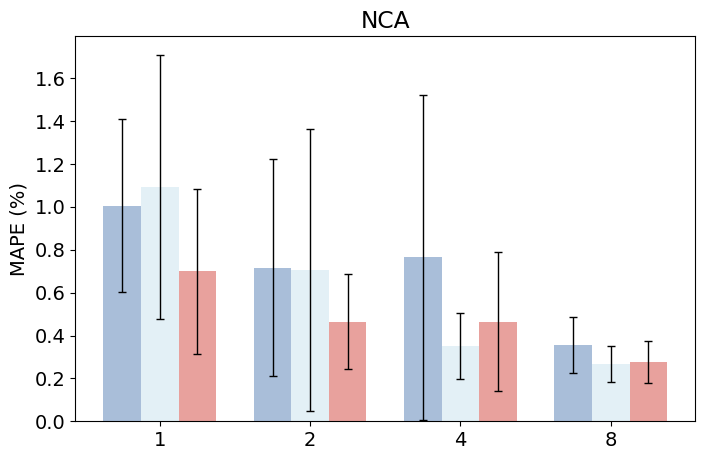

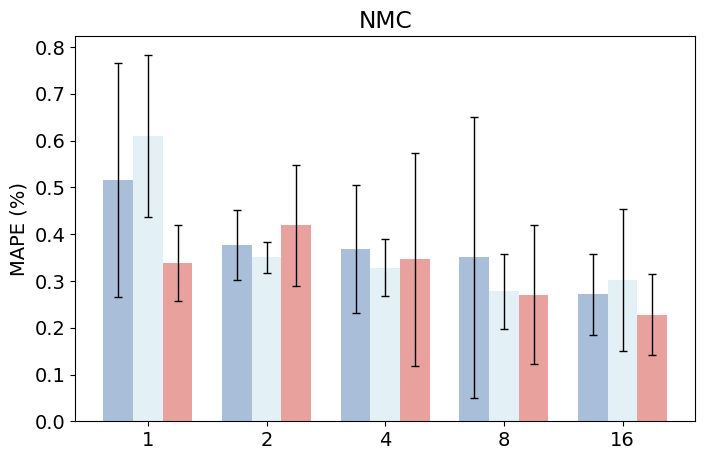

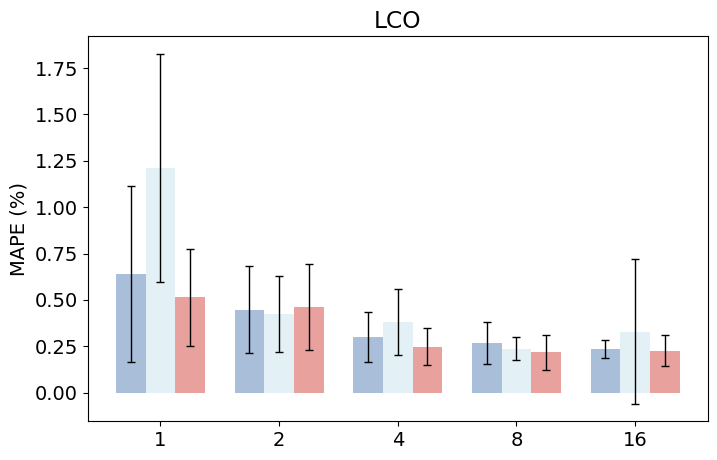

In [41]:
colors = ['#A9BED9', '#E3F0F6', '#E8A19D', '#FEE3C3']
train_count_map = {
    'NCA': [1, 2, 4, 8],
    'NMC': [1, 2, 4, 8, 16],
    'LCO': [1, 2, 4, 8, 16]
}

for material in train_count_map:
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    score_mat = np.random.rand(3, len(train_count_map[material]))
    std_mat = np.random.rand(3, len(train_count_map[material])) / 10

    for indx, train_count in enumerate(train_count_map[material]):
        folder = HOME / f'workspaces/transfer_compare/{material}_{train_count}'
        seed_scores = [[], [], []]
        for file in folder.glob('*.pkl'):
            with open(file, 'rb') as f:
                scores = pickle.load(f)
            seed_scores[0].append(mape(scores['intracd_preds'], scores['labels']))
            seed_scores[1].append(mape(scores['finetune_preds'], scores['labels']))
            seed_scores[2].append(mape(
                (scores['intracd_preds'] + scores['intercd_preds']) / 2, scores['labels']
            ))
            # seed_scores[2].append(mape(scores['intercd_preds'], scores['labels']))
        score_mat[0, indx] = np.mean(seed_scores[0])
        std_mat[0, indx] = np.std(seed_scores[0])

        # Finetune
        score_mat[1, indx] = np.mean(seed_scores[1])
        std_mat[1, indx] = np.std(seed_scores[1])

        # BatliNet
        score_mat[2, indx] = np.mean(seed_scores[2])
        std_mat[2, indx] = np.std(seed_scores[2])

    x = np.arange(len(train_count_map[material]))
    width = 1 / (len(score_mat) + 1)
    for indx, method_score in enumerate(score_mat):
        ax.bar(
            x + indx * width,
            method_score,
            yerr=std_mat[indx],
            width=width,
            color=colors[indx],
            error_kw=dict(capsize=3, capthick=1, lw=1),
            # error bar color is darker than grey
            ecolor='black'
        )
    ax.set_title(material)
    ax.set_xticks(x + (len(score_mat) - 1) * width / 2, train_count_map[material])
    ax.set_ylabel('MAPE (%)')
    plt.show()

In [12]:
def calculate_mean_std(values):  
    mean = sum(values) / len(values)  
    std = (sum((x - mean) ** 2 for x in values) / len(values)) ** 0.5  
    return mean, std  
  
def reorganize_results(scores):  
    reorganized_scores = {}  
      
    for material, fractions in scores.items():  
        reorganized_scores[material] = {}  
          
        for indx, (fraction, seeds) in enumerate(fractions.items()):  
            for seed_results in seeds:  
                for model, errors in seed_results.items():  
                    if model not in reorganized_scores[material]:  
                        reorganized_scores[material][model] = {  
                            'RMSE': [[] for _ in range(4)],
                            'MAPE': [[] for _ in range(4)]
                        }  
                    print(errors)
                      
                    rmse, mape = errors
                    reorganized_scores[material][model]['RMSE'][indx]\
                        .append(rmse)
                    reorganized_scores[material][model]['MAPE'][indx]\
                        .append(mape)
                      
        for model in reorganized_scores[material]:  
            for error_type in reorganized_scores[material][model]:  
                for indx, frac in enumerate(
                    reorganized_scores[material][model][error_type]
                ):
                    mean, std = calculate_mean_std(frac)  
                    reorganized_scores[material][model][error_type][indx] = {  
                        'mean': mean,
                        'std': std
                    }  
                      
    return reorganized_scores  

results = reorganize_results(scores)

tensor([158.8627,  82.6711,  62.0502,  93.0466,  71.0154,  42.8316,  48.2227,
         12.0013,  74.5458,  60.8655,  87.3047, 153.8281,  96.0850,  13.6771,
         12.8490,  84.7832, 146.4054,  32.5342,  86.3101, 142.2991, 156.4070])


ValueError: too many values to unpack (expected 2)

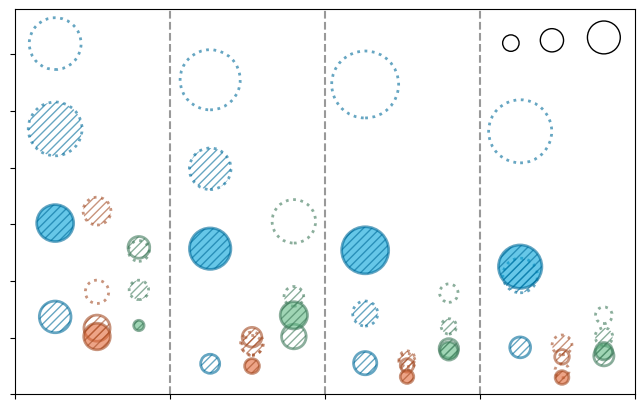

In [5]:
import numpy as np    
import matplotlib as mpl
import matplotlib.pyplot as plt    

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
colors = ['#00A3DA',  '#E26837', '#61B984','#5ABEC1', '#E780A9', '#DF5555']    
edge_colors = ['#006B9A', '#A44D26', '#3E795A', '#3C8C99', '#A64B77', '#A13B3B']
hatches = ['////', '', '////', '////']  
edge_styles = ['solid', 'dotted', 'dotted', 'solid']  

ratio = 2.8
  
# Offset for different vertical lines    
width = 0.3
offsets = np.linspace(-width*0.8, width*1, 3)
for offset, (color, edge_color, material) in enumerate(zip(colors, edge_colors, results)):    
    for method, (hatch, edge_style) in zip(results[material], zip(hatches, edge_styles)):    
        means = [x['mean'] for x in results[material][method]['RMSE']]    
        stds = [x['std'] for x in results[material][method]['RMSE']]    
    
        # Adjust marker size based on std    
        sizes = [ratio * std for std in stds]  
    
        # Place markers on different vertical lines    
        x_values = np.arange(4) + offsets[offset]  
  
        facecolor = 'none' if method != 'combine_scores' else color  
    
        ax.scatter(    
            x_values, means,    
            s=sizes, marker='o',    
            facecolor=facecolor,  
            edgecolor=edge_color,  
            hatch=hatch,    
            alpha=0.6,  
            linewidths=2,  
            linestyle=edge_style,  
            label=f'{material}_{method}')    

ax.vlines([0.5, 1.5, 2.5], 100, 780,
          color='grey', linestyle='dashed', alpha=0.8)
ax.set_xlim([-0.5, 3.5])
ax.set_xticks(np.arange(-0.5, 3.6, 1), labels=[])
ax.set_yticks(np.arange(100, 701, 100), labels=[])

ax.set_ylim([100, 780])
    
ax.scatter(2.7, 720, s=50 * ratio, marker='o', color='black', facecolor='none')
ax.scatter(2.965, 725, s=100 * ratio, marker='o', color='black', facecolor='none')
ax.scatter(3.3, 730, s=200 * ratio, marker='o', color='black', facecolor='none')
# t = mpl.markers.MarkerStyle(marker='|')
# t._transform = t.get_transform().rotate_deg(90)
# ax.scatter(2.7, 680, s=50 * ratio, marker=t, color='black')
# ax.scatter(2.9, 680, s=100 * ratio, marker=t, color='black')
# ax.scatter(3.2, 680, s=200 * ratio, marker=t, color='black')

# plt.legend(bbox_to_anchor=(1, 1))    
fig.savefig(
    'visualization/temp/transfer.svg',
    bbox_inches='tight',
    pad_inches=0.1)
plt.show()    


In [10]:
results['NCA'].keys()

dict_keys(['intercd_scores', 'intracd_scores', 'finetune_scores', 'combine_scores'])

In [9]:
x = np.arange(4)
width = 0.18
colors = ['#A9BED9', '#E3F0F6', '#FEE3C3', '#E8A19D']
methods = [
    'intracd_scores',
    'finetune_scores',
    'intercd_scores',
    'combine_scores'
]
for material in results:
    fig, ax = plt.subplots(figsize=(6, 4))
    for indx, method in enumerate(methods):
        method_result = results[material][method]
        rmses = method_result['RMSE']
        means = [x['mean'] for x in rmses]
        stds = [x['std'] for x in rmses]
        ax.bar(
            x+indx*width,
            means,
            width=width,
            label=method,
            color=colors[indx],
            yerr=stds,
            error_kw=dict(capsize=3, capthick=1, lw=1),
            # error bar color is darker than grey
            ecolor='black')
    # ax.legend()
    ylim = ax.get_ylim()
    ax.set_ylim([0, ylim[1]])
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(['5%', '10%', '15%', '20%'])
    ax.set_title(material)
    plt.show()

NameError: name 'results' is not defined

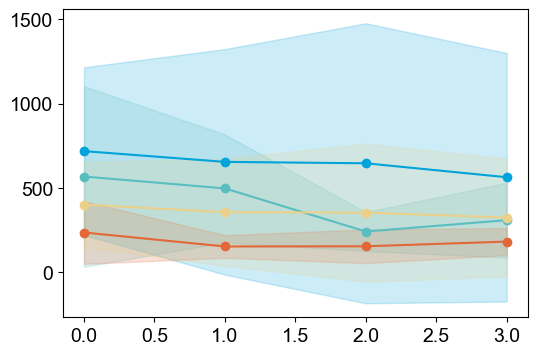

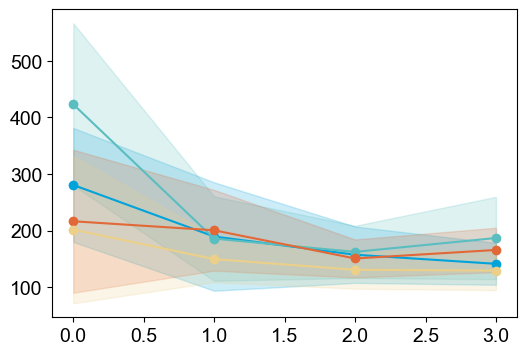

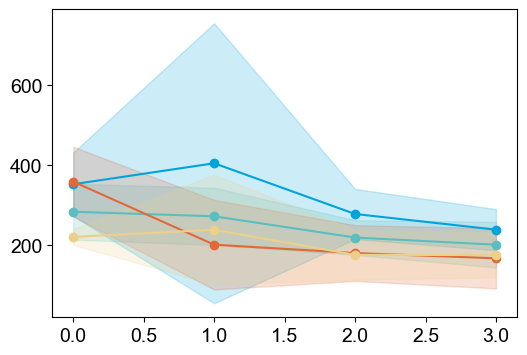

In [26]:
x = np.arange(4)
width = 0.18
colors = ['#00A3DA', '#5ABEC1', '#E26837', '#ECD089']
methods = [
    'intracd_scores',
    'finetune_scores',
    'intercd_scores',
    'combine_scores'
]
for material in results:
    fig, ax = plt.subplots(figsize=(6, 4))
    for indx, method in enumerate(methods):
        method_result = results[material][method]
        rmses = method_result['RMSE']
        means = np.array([x['mean'] for x in rmses])
        stds = np.array([x['std'] for x in rmses])
        x = np.arange(4)
        ax.plot(x, means, 'o-', color=colors[indx])
        ax.fill_between(x, means+stds, means-stds, color=colors[indx], alpha=0.2)
        # ax.bar(
        #     x+indx*width,
        #     means,
        #     width=width,
        #     label=method,
        #     color=colors[indx],
        #     yerr=stds,
        #     error_kw=dict(capsize=3, capthick=1, lw=1),
        #     # error bar color is darker than grey
        #     ecolor='black')
    plt.show()

In [16]:
workspace =  Path('/workspace/battery/nmi_configs/workspaces/transfer')
preds = defaultdict(dict)
for path in workspace.glob('*'):
    mat, train_frac = path.name.split('_')
    preds_ = []
    for pred_file in path.glob('preds*.pkl'):
        with open(pred_file, 'rb') as f:
            pred = pickle.load(f)
        preds_.append(pred)
    preds[mat][train_frac] = preds_


In [45]:
res = defaultdict(dict)
for material in ['NMC', 'LCO', 'NCA']:
    means, stds = [], []
    for train_frac in ['0.05', '0.1', '0.15', '0.2']:
        scores = [[], [], [], [], []]
        for seed in range(8):
            seed_preds = preds[material][train_frac][seed]
            scores[0].append(rmse(
                seed_preds['intercd_preds'], seed_preds['labels']
            ))
            scores[1].append(rmse(
                seed_preds['intracd_preds'], seed_preds['labels']
            ))
            scores[2].append(rmse(
                seed_preds['finetune_preds'], seed_preds['labels']
            ))
            scores[3].append(rmse(
                (seed_preds['intracd_preds'] + seed_preds['intercd_preds']) / 2,
                seed_preds['labels']))
            scores[4].append(rmse(
                (seed_preds['finetune_preds'] + seed_preds['intercd_preds']) / 2,
                seed_preds['labels']
            ))
        means.append([np.mean(x) for x in scores])
        stds.append([np.std(x) for x in scores])
    res[material]['means'] = means
    res[material]['stds'] = stds

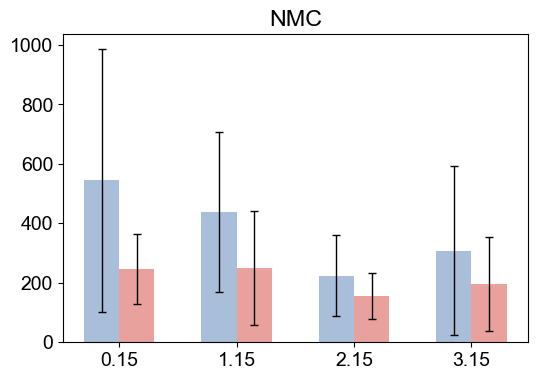

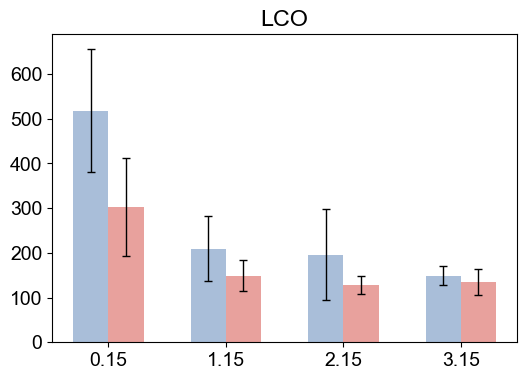

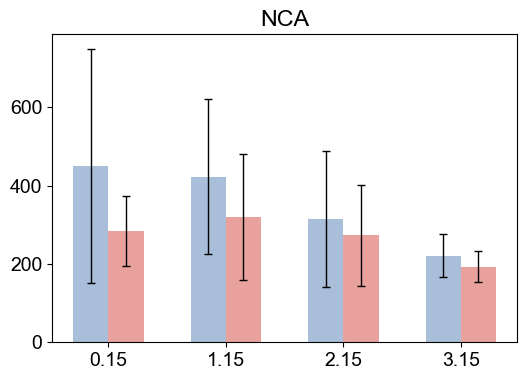

In [71]:
# colors = ['#A9BED9', '#E3F0F6', '#FEE3C3', '#E8A19D']
colors = ['#A9BED9', '#E8A19D']
for material in ['NMC', 'LCO', 'NCA']:
    means, stds, mins, maxs = [], [], [], []
    for train_frac in ['0.05', '0.1', '0.15', '0.2']:
        scores = [[], [], [], [], []]
        for seed in range(8):
            seed_preds = preds[material][train_frac][seed]
            scores[0].append(rmse(
                seed_preds['intercd_preds'], seed_preds['labels']
            ))
            scores[1].append(rmse(
                seed_preds['intracd_preds'], seed_preds['labels']
            ))
            scores[2].append(rmse(
                seed_preds['finetune_preds'], seed_preds['labels']
            ))
            scores[3].append(rmse(
                (seed_preds['intracd_preds'] + seed_preds['intercd_preds']) / 2,
                seed_preds['labels']))
            scores[4].append(rmse(
                (seed_preds['finetune_preds'] + seed_preds['intercd_preds']) / 2,
                seed_preds['labels']
            ))
        means.append([np.mean(x) for x in scores])
        stds.append([np.std(x) for x in scores])
        mins.append([np.min(x) for x in scores])
        maxs.append([np.max(x) for x in scores])
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    x = np.arange(4)
    ax.bar(
        x,
        [i[2] for i in means],
        width=0.3,
        color=colors[0],
        yerr=[i[2] for i in stds],
        error_kw=dict(capsize=3, capthick=1, lw=1),
        # error bar color is darker than grey
        ecolor='black')
    ax.bar(
        x+0.3,
        [i[3] for i in means],
        width=0.3,
        color=colors[1],
        yerr=[i[3] for i in stds],
        error_kw=dict(capsize=3, capthick=1, lw=1),
        # error bar color is darker than grey
        ecolor='black')
    # plt.plot(x, [i[2] for i in means], color=colors[2])
    # plt.fill_between(
    #     x,
    #     [i[2] for i in mins],
    #     [i[2] for i in maxs],
    #     color=colors[2],
    #     alpha=0.2)
    # plt.plot(x, [i[3] for i in means], color=colors[0])
    # plt.fill_between(
    #     x,
    #     [i[3] for i in mins],
    #     [i[3] for i in maxs],
    #     color=colors[0],
    #     alpha=0.2)
    ax.set_xticks(x+0.15)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    # fig.savefig(
    #     f'visualization/temp/transfer_bar_{material}.svg',
    #     bbox_inches='tight',
    #     pad_inches=0.1)
    ax.set_title(material)
    plt.show()

In [46]:
res['LCO']['means']

[[349.6644, 293.61737, 518.19434, 302.42053, 295.94852],
 [188.65976, 154.9631, 209.23668, 149.0373, 152.56898],
 [142.86755, 172.44165, 195.87622, 128.09717, 133.5754],
 [162.37973, 138.53162, 148.77235, 134.4039, 135.48721]]

In [47]:
res['NMC']['means']

[[283.1127, 373.94604, 544.8027, 246.5877, 340.9865],
 [194.38538, 404.38635, 437.14166, 250.48438, 251.07402],
 [180.73859, 203.41724, 224.03847, 156.36008, 156.90895],
 [126.7525, 313.26318, 308.6454, 196.51277, 188.4578]]

In [33]:
res['NCA']['means']

[[402.1471, 380.3934, 449.95004, 284.4622, 301.5434],
 [463.4574, 384.9376, 422.85742, 320.74155, 278.3755],
 [293.43445, 348.922, 313.76556, 272.93988, 246.76224],
 [202.3588, 261.66888, 221.44238, 193.39386, 179.22061]]

In [35]:
res['LCO']['stds']

[[153.13799, 93.217636, 137.97356, 108.78451, 63.67444],
 [68.37973, 48.253296, 72.1538, 34.397038, 34.702854],
 [36.734245, 34.423923, 101.91016, 19.108438, 44.72893],
 [61.851913, 20.520359, 21.419664, 29.72697, 34.449722]]